<a href="https://colab.research.google.com/github/Samarth-991/TimeSeries/blob/master/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install yahoo_fin --upgrade
!pip install requests_html

Requirement already up-to-date: yahoo_fin in /usr/local/lib/python3.6/dist-packages (0.8.6)


In [ ]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import deque
from yahoo_fin import stock_info as si

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random
#https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

In [ ]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

## Load Data function
First, it loads the dataset using stock_info.get_data() function in yahoo_fin module.
If the scale argument is passed as True, it will scale all the prices from 0 to 1 (including the volume) using the sklearn's MinMaxScaler class. Note that each column has its own scaler.
It then adds the future column which indicates the target values (the labels to predict, or the y's) by shifting the adjusted close column by lookup_step.
After that, it shuffles and splits the data and returns the result.


In [ ]:
def load_data(ticker, n_steps=100, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low'],save_df=True):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
        if save_df:
          df.to_csv(ticker+'.csv',index=True)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result
N_STEPS=50
ticker='ITC.NS'
data = load_data(ticker,n_steps=N_STEPS)

In [ ]:
# analysis of the plot 
stockdf = pd.read_csv(ticker+'.csv')
stockdf.tail(10)


,Unnamed: 0,open,high,low,close,adjclose,volume,ticker
6194,2020-07-28,197.000000,198.649994,195.050003,195.399994,195.399994,19287132.0,ITC.NS
6195,2020-07-29,193.449997,198.199997,193.399994,196.699997,196.699997,14831635.0,ITC.NS
6196,2020-07-30,198.399994,198.399994,192.500000,193.350006,193.350006,16315231.0,ITC.NS
6197,2020-07-31,193.500000,196.949997,193.500000,194.149994,194.149994,16652851.0,ITC.NS
6198,2020-08-03,194.000000,194.000000,191.899994,192.600006,192.600006,13265411.0,ITC.NS
6199,2020-08-04,192.600006,195.800003,192.600006,193.649994,193.649994,17187619.0,ITC.NS
6200,2020-08-05,194.500000,194.600006,191.699997,192.800003,192.800003,48768332.0,ITC.NS
6201,2020-08-06,194.199997,195.600006,193.100006,195.350006,195.350006,17886089.0,ITC.NS
6202,2020-08-07,195.500000,197.000000,194.149994,196.050003,196.050003,20911818.0,ITC.NS
6203,2020-08-10,196.399994,199.649994,196.399994,198.350006,198.350006,7397301.0,ITC.NS


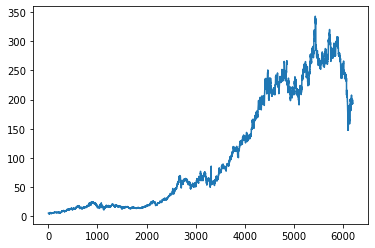

In [ ]:

stockdf['close'].plot()

In [ ]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
print (data['X_train'].shape)
print (data['X_test'].shape)
print (data['y_train'].shape)
print (data['y_test'].shape)

(4732, 5, 50)
(1183, 5, 50)
(4732,)
(1183,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,Input,GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD,Adam


In [ ]:
i = Input(shape=(X_train.shape[1],X_train.shape[2]))
layer1 = Bidirectional(LSTM(512,kernel_regularizer=l2(0.01),return_sequences=True))(i)
layer2 = Bidirectional(LSTM(512,kernel_regularizer=l2(0.01),return_sequences=True))(layer1)
layer3= Bidirectional(LSTM(128,return_sequences=False))(layer2)
output =Dense(1,activation='linear')(layer3)
model = Model(i,output) 
model.compile(loss='mean_absolute_error',metrics=["mean_absolute_error"], optimizer='rmsprop')

In [ ]:
tensorboard = TensorBoard(log_dir=os.path.join("logs", "STOCK_model"))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 50)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 1024)           2306048   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 1024)           6295552   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               1180672   
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 9,782,529
Trainable params: 9,782,529
Non-trainable params: 0
_________________________________________________________________


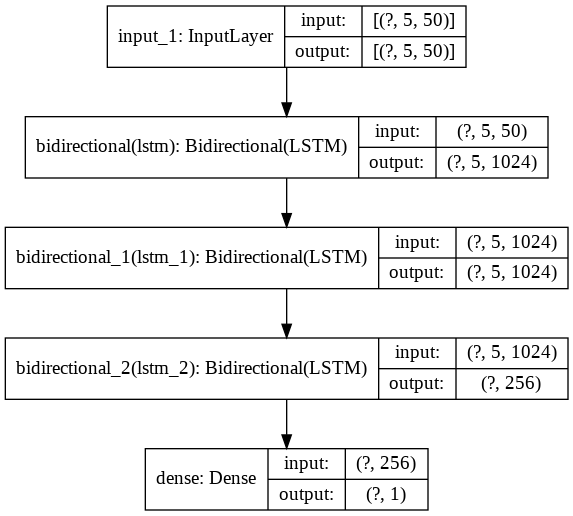

In [ ]:
model.summary()
from keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes=True)

In [ ]:
BATCH_SIZE = 256
EPOCHS = 200
H = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,callbacks=[tensorboard],
                    epochs=EPOCHS,validation_split=0.3)


Epoch 1/200
 1/13 [=>............................] - ETA: 0s - loss: 29.5197 - mean_absolute_error: 0.2742WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
13/13 [==============================] - 2s 173ms/step - loss: 15.4997 - mean_absolute_error: 0.3293 - val_loss: 7.2670 - val_mean_absolute_error: 0.1542
Epoch 2/200
13/13 [==============================] - 0s 36ms/step - loss: 4.4443 - mean_absolute_error: 0.1071 - val_loss: 2.2495 - val_mean_absolute_error: 0.1868
Epoch 3/200
13/13 [==============================] - 0s 36ms/step - loss: 1.2940 - mean_absolute_error: 0.1192 - val_loss: 0.6425 - val_mean_absolute_error: 0.1422
Epoch 4/200
13/13 [==============================] - 0s 35ms/step - loss: 0.3884 - mean_absolute_error: 0.0926 - val_loss: 0.2013 - va

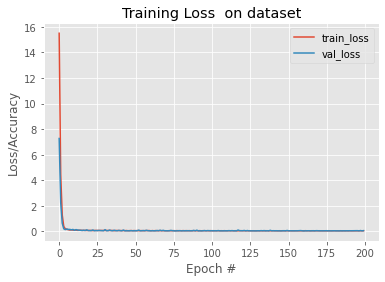

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H.history["mean_absolute_error"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_mean_absolute_error"], label="val_acc")
plt.title("Training Loss  on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [ ]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)

# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 12.406585020359277


In [ ]:
print (mae)
print (mse)

0.03955680504441261
0.058678168803453445


In [ ]:
# retrieve the last sequence from data
last_sequence = data["last_sequence"][:N_STEPS]
# retrieve the column scalers
column_scaler = data["column_scaler"]
print (last_sequence.shape)

(50, 5)


In [ ]:
last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
last_sequence = np.expand_dims(last_sequence, axis=0)
print (last_sequence.shape)

(1, 5, 50)


In [ ]:
prediction = model.predict(last_sequence)
prediction = prediction+mse-mae
predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
print(predicted_price)
print(predicted_price+mean_absolute_error)
print(predicted_price-mean_absolute_error)

213.54152
225.94810418539834
201.1349341446798


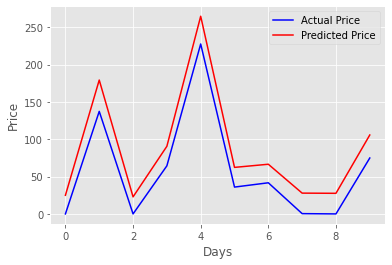

In [ ]:
y_test = data["y_test"]
X_test = data["X_test"]

y_pred = model.predict(X_test)
y_pred = y_pred+mse
y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
# last 200 days, feel free to edit that
plt.plot(y_test[-10:], c='b')
plt.plot(y_pred[-10:], c='r')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(["Actual Price", "Predicted Price"])
plt.show()
